# Custom CNN for HER2 IHC Image Classification
## Info
### Version: V1.1.0
#### Changes:
Changes from V1.0.0 has been made on the epoch number and the Accuracy has been improved too!

In [60]:
# Version information
version_info = """
Project Version: 1.0.0
Release Date: 2025-01-15
Author: Saky
"""

In [62]:
# Write to version.txt
with open("/kaggle/working/version.txt", "w") as f:
    f.write(version_info)

# Check the content by reading it back
with open("/kaggle/working/version.txt", "r") as f:
    print(f.read())


Project Version: 1.0.0
Release Date: 2025-01-15
Author: Saky



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import shap
from keras.preprocessing import image
import tensorflow.keras.backend as K

In [2]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is enabled!")
else:
    print("GPU is not enabled.")

GPU is enabled!


In [3]:
# Path to your dataset
train_dir = "/kaggle/input/train-pvt-intnsty"
test_dir = "/kaggle/input/test-pvt-intnsty"

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,               # Normalize pixel values
    rotation_range=40,               # Random rotations
    width_shift_range=0.2,           # Random horizontal shifts
    height_shift_range=0.2,          # Random vertical shifts
    shear_range=0.2,                 # Random shear
    zoom_range=0.2,                  # Random zoom
    horizontal_flip=True,            # Random horizontal flip
    fill_mode='nearest'              # Fill missing pixels
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=False
)


Found 9689 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [4]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential()
    
    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Flatten and Dense Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes for multi-class classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build and summarize the model
model = build_custom_cnn()
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,348 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Adjust epochs based on dataset size and performance
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/50


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


302/302 ━━━━━━━━━━━━━━━━━━━━ 277s 878ms/step - accuracy: 0.6799 - loss: 0.7252 - val_accuracy: 0.8629 - val_loss: 0.3773
Epoch 2/50
  1/302 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9062 - loss: 0.2760

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.2760 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 3/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 178s 578ms/step - accuracy: 0.8521 - loss: 0.3867 - val_accuracy: 0.7843 - val_loss: 0.4996
Epoch 4/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - accuracy: 0.6250 - loss: 0.6353 - val_accuracy: 1.0000 - val_loss: 6.2704e-04
Epoch 5/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 174s 562ms/step - accuracy: 0.8520 - loss: 0.3908 - val_accuracy: 0.8246 - val_loss: 0.3999
Epoch 6/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.7812 - loss: 0.4210 - val_accuracy: 1.0000 - val_loss: 0.0631
Epoch 7/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 176s 571ms/step - accuracy: 0.8573 - loss: 0.3769 - val_accuracy: 0.8564 - val_loss: 0.3476
Epoch 8/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - accuracy: 1.0000 - loss: 0.1342 - val_accuracy: 0.9375 - val_loss: 0.1104
Epoch 9/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 175s 569ms/step - accuracy: 0.8728 - loss: 0.3392 - v

In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")

62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.9257 - loss: 0.2588
Test accuracy: 94.61%


# Prediction and Generating Reports

In [7]:
# Generate predictions for the validation or test set
predictions = model.predict(test_generator)  # Ensure you use the correct generator
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true labels from the generator
true_classes = test_generator.classes  # Ensure you use the same generator as in the prediction step

# Check the number of samples in true and predicted classes
print(f"Number of true labels: {len(true_classes)}")
print(f"Number of predicted labels: {len(predicted_classes)}")

# Ensure the lengths match
if len(true_classes) != len(predicted_classes):
    raise ValueError("Mismatch in number of true and predicted samples. Check the generator settings.")

# Get the class indices to use target names in the report
target_names = list(test_generator.class_indices.keys())

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=target_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step
Number of true labels: 2000
Number of predicted labels: 2000
              precision    recall  f1-score   support

     class_0       0.97      0.92      0.95       716
    class_1+       0.82      0.93      0.87       342
    class_2+       0.94      0.88      0.91       189
    class_3+       0.99      0.99      0.99       753

    accuracy                           0.95      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.95      0.95      0.95      2000



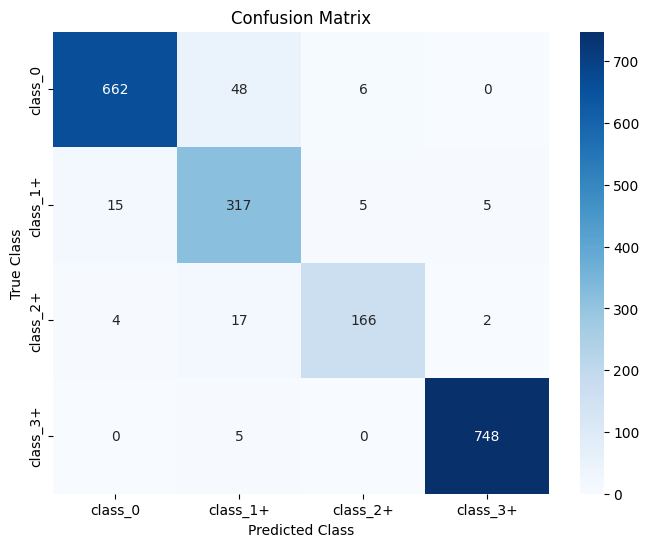

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

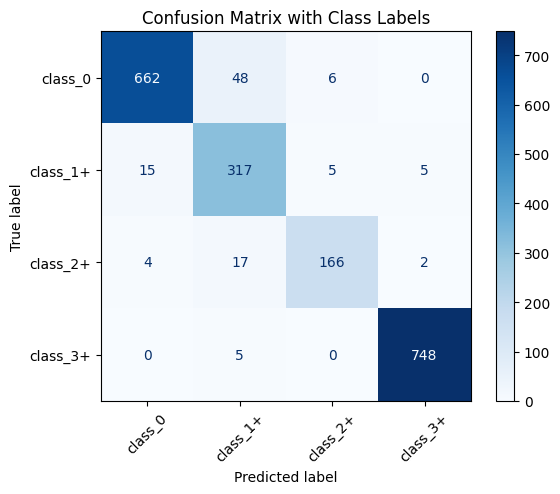

In [9]:
# Optional: Use sklearn's built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix with Class Labels")
plt.show()

In [10]:
# Specify the path where you want to save the model
model_save_path = "/kaggle/working/custom_cnn_model_updated.h5"  # Use .h5 for HDF5 format or .tf for TensorFlow SavedModel format

# Save the trained model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/custom_cnn_model_updated.h5


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,350 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [42]:
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
flatten
dense
dropout
dense_1
